In [1]:
import librosa
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import os
import seaborn as sns
from scipy.signal import butter, lfilter
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.activations import relu, tanh, linear
from tensorflow.keras.utils import Progbar
from joblib import Parallel, delayed #Paralleize calculation
import psycopg2
from sqlalchemy import create_engine, Column, Integer, ARRAY, MetaData, Table, Text
from sqlalchemy.dialects.postgresql import ARRAY as PG_ARRAY
from psycopg2.extensions import register_adapter, AsIs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# check if tensorflow uses GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-01-07 15:01:08.897816: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-07 15:01:08.897964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-07 15:01:08.976772: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-07 15:01:09.110999: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-07 15:01:10.291530: W tensorflow/compiler/tf2

Num GPUs Available:  1


In [2]:
# Custom adapter function for postgre
def adapt_numpy_ndarray(numpy_array):
    return AsIs(list(numpy_array))
# Register the postgre-adapter
register_adapter(np.ndarray, adapt_numpy_ndarray)

# Database connection parameters and alchemy engine
dbname = 'bathunting'
user = 'python'
password = 'python_password'
host = 'localhost'
port = '5432' 
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}')

# Functions to get data
def get_target_data(target, limit=0, no_target=False):
    lmt = "" if limit<=0 else f"LIMIT {limit}"
    #query = ""
    if no_target:
        query = f"SELECT new_arr FROM batcall where 10 < ANY(new_arr) and target = {target} {lmt}"
    else:
        query = f"SELECT target, new_arr FROM batcall where 10 < ANY(new_arr) and target = {target} {lmt}"
    df = pd.read_sql_query(query, engine)
    if no_target:
        df = pd.DataFrame(df['new_arr'].tolist())
    return df

# messy, i know
def get_targets_to_data(limit=0):
    lmt = "" if limit<=0 else f"LIMIT {limit}"
    query = f"SELECT target FROM batcall where 10 < ANY(new_arr) {lmt}"
    df = pd.read_sql_query(query, engine)
    return df

def get_all_data(targets=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], limit=0, no_target=False):
    all_df = Parallel(n_jobs=-3, prefer="threads")(delayed(get_target_data)(target, limit, no_target) for target in targets)
    return all_df

def get_data(targets=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], limit=0, no_target=False):
    all_df = Parallel(n_jobs=-3, prefer="threads")(delayed(get_target_data)(target, limit, no_target) for target in targets)
    df = pd.concat(all_df)
    return df

# try to visualize only the maximum values per species
def spectrogram_range(target):
    df = get_target_data(target, limit=0, no_target=True)
    max_vals = df.max()
    min_vals = df.min()
    
    abs_pos = max_vals.abs()
    abs_neg = min_vals.abs()
    mask = (abs_pos > abs_neg).astype(bool)
    return min_vals.where(mask, max_vals), max_vals.where(mask, min_vals)

def get_targets():
    #conn = psycopg2.connect(dbname=dbname, user=user, password=password, host=host)
    #cursor = conn.cursor()
    query = f"SELECT target, bat FROM batcall group by target, bat order by target"
    df = pd.read_sql_query(query, engine)
    #conn.close()
    return df

def get_shape(nested_list):
    try:
        # Initialize shape list
        shape = []

        # Iterate to calculate the shape
        while isinstance(nested_list, list) or isinstance(nested_list, np.ndarray):
            shape.append(len(nested_list))
            nested_list = nested_list[0]

        return tuple(shape)
    except (TypeError, IndexError) as e:
        # In case the nested lists are not uniformly sized
        return f"Irregular shape - nested lists are not of equal size. \n ERROR: {e}"
    
# Get data to work with
def get_features_and_targets(limit=100, scaler=StandardScaler(), categorical=True):
    data = get_data(limit=limit)

    df = pd.DataFrame(data["new_arr"].tolist())
    if scaler != None:
        df = scaler.fit_transform(df)

    labels = pd.DataFrame(data["target"])
    if categorical:
        labels = to_categorical(labels, num_classes=19)
    return df, labels

def vogl_conversion(df):
    data_reshaped = []
    for _,data in df.iterrows():
        # Normalize
        data -= np.mean(data)
        data /= np.std(data)

        # Realy no idea just assuming prof did it right
        # Calculate spectrogram with FFT
        stft = np.abs(librosa.stft(np.array(data), n_fft=512, hop_length=32))
        stft = 10 * np.log10(stft)
        stft = np.nan_to_num(stft)
        # Scale between [0,1] and reduce shape if needed
        stft = (stft - np.min(stft)) / (np.max(stft) - np.min(stft))
        stft = np.reshape(stft, (257, 138, 1))
        stft = stft[:256, -128: , :]
        data_reshaped.append(stft)
    return np.array(data_reshaped)

In [3]:
# Checking the shape
df_scaled, labels = get_features_and_targets()
print(labels.shape)
print(df_scaled.shape)

(1900, 19)
(1900, 4410)


## PCA

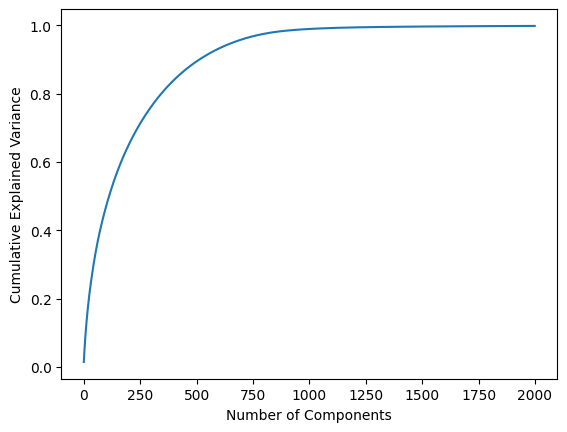

In [57]:
# PCA
pca = PCA(n_components=2000)  # 2000 -> nicht gut für die CPU
df_pca = pca.fit_transforml.add(Conv2D(32, (3,3), activation='relu'))
model(df_scaled)

# The transformed data as a DataFrame
df_pca = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# Explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)
# Some nice plote
plt.plot(explained_variance)
plt.xlabel('Number of Compon
print(labels.shape)ents')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [58]:
# As there is no "elbow" I decided 95% shell be good enough
cumulative_variance = 0.0
n_components = 0
for var in pca.explained_variance_ratio_:
    cumulative_variance += var
    n_components += 1
    if cumulative_variance >= 0.95:
        break

print(f"Number of components to retain 95% variance: {n_components}")

Number of components to retain 95% variance: 663


In [5]:
# Transform the data
pca = PCA(n_components=663)
pca.fit(df_scaled)
df_transformed = pca.transform(df_scaled)

# Creating a new DataFrame for the transformed data
df_transformed = pd.DataFrame(df_transformed, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

## Model training \#1

In [14]:
# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(df_transformed, labels, test_size=0.2, random_state=42)

In [23]:
# Determine the number of input features
input_dim = X_train.shape[1]

# Build the model
model = Sequential()
model.add(Dense(10, input_dim=input_dim, activation='relu'))
model.add(Dense(19, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [24]:
# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=10)  # Adjust epochs and batch_size as needed

Epoch 1/100
4102/4102 [==============================] - 13s 3ms/step - loss: 2.7275 - accuracy: 0.1910
Epoch 2/100
4102/4102 [==============================] - 13s 3ms/step - loss: 2.3056 - accuracy: 0.2874
Epoch 3/100
4102/4102 [==============================] - 13s 3ms/step - loss: 2.1463 - accuracy: 0.3324
Epoch 4/100
4102/4102 [==============================] - 13s 3ms/step - loss: 2.0560 - accuracy: 0.3630
Epoch 5/100
4102/4102 [==============================] - 13s 3ms/step - loss: 1.9991 - accuracy: 0.3760
Epoch 6/100
4102/4102 [==============================] - 14s 3ms/step - loss: 1.9576 - accuracy: 0.3816
Epoch 7/100
4102/4102 [==============================] - 13s 3ms/step - loss: 1.9256 - accuracy: 0.3916
Epoch 8/100
4102/4102 [==============================] - 13s 3ms/step - loss: 1.9008 - accuracy: 0.3958
Epoch 9/100
4102/4102 [==============================] - 13s 3ms/step - loss: 1.8764 - accuracy: 0.4009
Epoch 10/100
4102/4102 [==============================] - 13s 3m

In [25]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %.2f' % (accuracy*100))
print('Test Loss: %.2f' % (loss*100))

321/321 [==============================] - 1s 1ms/step - loss: 2.1865 - accuracy: 0.4103
Test Accuracy: 41.03


Wie man unschwer erkennen kann ist dieses sehr simple Model nicht wirklich gut geeignet.

## Model training \#2
... using only normalized data

In [30]:
data_reshaped = []
for _,data in df.iterrows():
    # Normalize
    data -= np.mean(data)
    data /= np.std(data)

    # Realy no idea just assuming prof did it right
    # Calculate spectrogram with FFT
    stft = np.abs(librosa.stft(np.array(data), n_fft=512, hop_length=32))
    stft = 10 * np.log10(stft)
    stft = np.nan_to_num(stft)
    # Scale between [0,1] and reduce shape if needed
    stft = (stft - np.min(stft)) / (np.max(stft) - np.min(stft))
    stft = np.reshape(stft, (257, 138, 1))
    stft = stft[:256, -128: , :]
    data_reshaped.append(stft)
df_reshaped = np.array(data_reshaped)

/tmp/ipykernel_2713/2456465814.py:10: RuntimeWarning: divide by zero encountered in log10
  stft = 10 * np.log10(stft)


In [31]:
# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(df_reshaped, labels, test_size=0.2, random_state=42)

In [26]:
# Determine the number of input features
input_dim = get_shape(X_train)[1:]

# Build the model
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=input_dim))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(19, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 126, 16)      160       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 63, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 61, 32)       4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 28, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 14, 64)       

In [33]:
# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=10)

Epoch 1/100


2024-01-04 14:04:48.513964: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-04 14:04:49.305985: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f5cf7ad6e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-04 14:04:49.306009: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-01-04 14:04:49.321921: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1704373489.440136    2912 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


152/152 [==============================] - 4s 7ms/step - loss: 2.9484 - accuracy: 0.0533
Epoch 2/100
152/152 [==============================] - 1s 7ms/step - loss: 2.9450 - accuracy: 0.0539
Epoch 3/100
152/152 [==============================] - 1s 7ms/step - loss: 2.9443 - accuracy: 0.0546
Epoch 4/100
152/152 [==============================] - 1s 7ms/step - loss: 2.9442 - accuracy: 0.0533
Epoch 5/100
152/152 [==============================] - 1s 7ms/step - loss: 2.9441 - accuracy: 0.0586
Epoch 6/100
152/152 [==============================] - 1s 7ms/step - loss: 2.9441 - accuracy: 0.0513
Epoch 7/100
152/152 [==============================] - 1s 7ms/step - loss: 2.9439 - accuracy: 0.0493
Epoch 8/100
152/152 [==============================] - 1s 7ms/step - loss: 2.9439 - accuracy: 0.0513
Epoch 9/100
152/152 [==============================] - 1s 7ms/step - loss: 2.9438 - accuracy: 0.0539
Epoch 10/100
152/152 [==============================] - 1s 7ms/step - loss: 2.9438 - accuracy: 0.0526
E

In [34]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %.2f' % (accuracy*100))
print('Test Loss: %.2f' % (loss*100))

12/12 [==============================] - 1s 24ms/step - loss: 2.9566 - accuracy: 0.0289
Test Accuracy: 2.89


... schlechter als auf den Daten die ausschließlich mit PCA vorverarbeitet wurden.

Wird's (signifikant) besser wenn mehr Daten betrachtet werden und der Scaler weggelassen wird?

## Model training \#3
... mehr Daten

In [37]:
df, labels = get_features_and_targets(limit=200, scaler=None)

In [38]:
data_reshaped = []
for _,data in df.iterrows():
    # Normalize
    data -= np.mean(data)
    data /= np.std(data)

    # Realy no idea just assuming prof did it right
    # Calculate spectrogram with FFT
    stft = np.abs(librosa.stft(np.array(data), n_fft=512, hop_length=32))
    stft = 10 * np.log10(stft)
    stft = np.nan_to_num(stft)
    # Scale between [0,1] and reduce shape if needed
    stft = (stft - np.min(stft)) / (np.max(stft) - np.min(stft))
    stft = np.reshape(stft, (257, 138, 1))
    stft = stft[:256, -128: , :]
    data_reshaped.append(stft)
df_reshaped = np.array(data_reshaped)

/tmp/ipykernel_2713/2456465814.py:10: RuntimeWarning: divide by zero encountered in log10
  stft = 10 * np.log10(stft)


In [39]:
X_train, X_test, y_train, y_test = train_test_split(df_reshaped, labels, test_size=0.2, random_state=42)
# Determine the number of input features
input_dim = get_shape(X_train)[1:]

# Build the model
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=input_dim))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(19, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 126, 16)      160       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 127, 63, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 61, 32)       4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 62, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 28, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 30, 14, 64)       

In [40]:
# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=10)

Epoch 1/100
304/304 [==============================] - 3s 7ms/step - loss: 2.9469 - accuracy: 0.0457
Epoch 2/100
304/304 [==============================] - 2s 6ms/step - loss: 2.9447 - accuracy: 0.0497
Epoch 3/100
304/304 [==============================] - 2s 7ms/step - loss: 2.9446 - accuracy: 0.0470
Epoch 4/100
304/304 [==============================] - 2s 6ms/step - loss: 2.9445 - accuracy: 0.0513
Epoch 5/100
304/304 [==============================] - 2s 7ms/step - loss: 2.9445 - accuracy: 0.0490
Epoch 6/100
304/304 [==============================] - 2s 7ms/step - loss: 2.9444 - accuracy: 0.0562
Epoch 7/100
304/304 [==============================] - 2s 7ms/step - loss: 2.9443 - accuracy: 0.0536
Epoch 8/100
304/304 [==============================] - 2s 7ms/step - loss: 2.9444 - accuracy: 0.0520
Epoch 9/100
304/304 [==============================] - 2s 7ms/step - loss: 2.9443 - accuracy: 0.0497
Epoch 10/100
304/304 [==============================] - 2s 7ms/step - loss: 2.9444 - accura

In [41]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %.2f' % (accuracy*100))
print('Test Loss: %.2f' % (loss*100))

24/24 [==============================] - 0s 14ms/step - loss: 2.9508 - accuracy: 0.0382
Test Accuracy: 3.82


## Model training \#4
 ... noch mehr Daten 

In [44]:
df, labels = get_features_and_targets(limit=500, scaler=None)

In [45]:
data_reshaped = []
for _,data in df.iterrows():
    # Normalize
    data -= np.mean(data)
    data /= np.std(data)

    # Realy no idea just assuming prof did it right
    # Calculate spectrogram with FFT
    stft = np.abs(librosa.stft(np.array(data), n_fft=512, hop_length=32))
    stft = 10 * np.log10(stft)
    stft = np.nan_to_num(stft)
    # Scale between [0,1] and reduce shape if needed
    stft = (stft - np.min(stft)) / (np.max(stft) - np.min(stft))
    stft = np.reshape(stft, (257, 138, 1))
    stft = stft[:256, -128: , :]
    data_reshaped.append(stft)
df_reshaped = np.array(data_reshaped)

/tmp/ipykernel_2713/2456465814.py:10: RuntimeWarning: divide by zero encountered in log10
  stft = 10 * np.log10(stft)


In [46]:
X_train, X_test, y_train, y_test = train_test_split(df_reshaped, labels, test_size=0.2, random_state=42)
# Determine the number of input features
input_dim = get_shape(X_train)[1:]

# Build the model
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=input_dim))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(19, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 126, 16)      160       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 127, 63, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 61, 32)       4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 62, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 28, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 30, 14, 64)       

In [47]:
# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=10)

Epoch 1/100
726/726 [==============================] - 6s 7ms/step - loss: 2.9426 - accuracy: 0.0528
Epoch 2/100
726/726 [==============================] - 5s 7ms/step - loss: 2.9392 - accuracy: 0.0500
Epoch 3/100
726/726 [==============================] - 5s 7ms/step - loss: 2.9380 - accuracy: 0.0579
Epoch 4/100
726/726 [==============================] - 5s 7ms/step - loss: 2.9377 - accuracy: 0.0585
Epoch 5/100
726/726 [==============================] - 5s 7ms/step - loss: 2.9375 - accuracy: 0.0585
Epoch 6/100
726/726 [==============================] - 5s 7ms/step - loss: 2.9375 - accuracy: 0.0585
Epoch 7/100
726/726 [==============================] - 5s 7ms/step - loss: 2.9374 - accuracy: 0.0585
Epoch 8/100
726/726 [==============================] - 5s 7ms/step - loss: 2.9374 - accuracy: 0.0579
Epoch 9/100
726/726 [==============================] - 5s 7ms/step - loss: 2.9374 - accuracy: 0.0585
Epoch 10/100
726/726 [==============================] - 5s 7ms/step - loss: 2.9374 - accura

In [48]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %.2f' % (accuracy*100))

57/57 [==============================] - 1s 8ms/step - loss: 2.9401 - accuracy: 0.0419
Test Accuracy: 4.19


## Model training \#5
... evtl. ein anderer Optimizer? Wie siehts mit Root Mean Square Propagation aus?

In [49]:
# Build the model
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=input_dim))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(19, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 254, 126, 16)      160       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 127, 63, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 125, 61, 32)       4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 62, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 28, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 30, 14, 64)       

In [50]:
# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=10)

Epoch 1/100
726/726 [==============================] - 6s 7ms/step - loss: 2.9454 - accuracy: 0.0532
Epoch 2/100
726/726 [==============================] - 5s 7ms/step - loss: 2.9391 - accuracy: 0.0580
Epoch 3/100
726/726 [==============================] - 5s 7ms/step - loss: 2.9380 - accuracy: 0.0565
Epoch 4/100
726/726 [==============================] - 5s 7ms/step - loss: 2.9377 - accuracy: 0.0585
Epoch 5/100
726/726 [==============================] - 5s 7ms/step - loss: 2.9375 - accuracy: 0.0585
Epoch 6/100
726/726 [==============================] - 5s 7ms/step - loss: 2.9374 - accuracy: 0.0572
Epoch 7/100
726/726 [==============================] - 5s 7ms/step - loss: 2.9374 - accuracy: 0.0574
Epoch 8/100
726/726 [==============================] - 5s 7ms/step - loss: 2.9374 - accuracy: 0.0585
Epoch 9/100
726/726 [==============================] - 5s 7ms/step - loss: 2.9375 - accuracy: 0.0568
Epoch 10/100
726/726 [==============================] - 5s 7ms/step - loss: 2.9375 - accura

In [51]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %.2f' % (accuracy*100))
print('Test Loss: %.2f' % (loss*100))

57/57 [==============================] - 0s 5ms/step - loss: 2.9402 - accuracy: 0.0419
Test Accuracy: 4.19


 alles Mist!

## Model training \#6
... PCA aber anders

In [4]:
df, labels = get_features_and_targets(limit=500, scaler=None)
df_reshaped = vogl_conversion(df)

In [6]:
pca_data = []
for data in df_reshaped:
    data = np.reshape(data, data.shape[:2])
    # PCA
    pca = PCA(n_components=20)
    pca.fit(data)
    data = pca.transform(data)
    #data = pd.DataFrame(data, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    pca_data.append(data)

In [7]:
pca_data=np.array(pca_data)
X_train, X_test, y_train, y_test = train_test_split(pca_data, labels, test_size=0.2, random_state=42)
X_train = X_train[:-3]
y_train = y_train[:-3]
print(get_shape(X_train))
print(get_shape(y_train))
# Determine the number of input features
input_dim = get_shape(X_train)

(7250, 256, 20)
(7250, 19)


Try several models

In [77]:
#########
### 1.0 ###
#########
# Most simple
# Build the model
model = Sequential()
model.add(Flatten())
model.add(Dense(10, input_dim=input_dim[1:], activation='relu'))
model.add(Dense(19, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [78]:
# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=10)
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %.2f' % (accuracy*100))
print('Test Loss: %.2f' % (loss*100))

Epoch 1/100
725/725 [==============================] - 3s 3ms/step - loss: 2.2387 - accuracy: 0.3102
Epoch 2/100
725/725 [==============================] - 2s 3ms/step - loss: 1.4726 - accuracy: 0.5494
Epoch 3/100
725/725 [==============================] - 2s 3ms/step - loss: 1.1268 - accuracy: 0.6663
Epoch 4/100
725/725 [==============================] - 2s 3ms/step - loss: 0.8896 - accuracy: 0.7487
Epoch 5/100
725/725 [==============================] - 2s 3ms/step - loss: 0.7082 - accuracy: 0.8095
Epoch 6/100
725/725 [==============================] - 2s 3ms/step - loss: 0.5671 - accuracy: 0.8590
Epoch 7/100
725/725 [==============================] - 2s 3ms/step - loss: 0.4540 - accuracy: 0.8949
Epoch 8/100
725/725 [==============================] - 3s 4ms/step - loss: 0.3641 - accuracy: 0.9229
Epoch 9/100
725/725 [==============================] - 2s 3ms/step - loss: 0.2936 - accuracy: 0.9404
Epoch 10/100
725/725 [==============================] - 3s 4ms/step - loss: 0.2393 - accura

In [8]:
###########
### 1.1 ###
###########
# Most simple
# Build the model
model = Sequential()
model.add(Flatten())
model.add(Dense(500, input_dim=input_dim[1:], activation='relu'))
model.add(Dense(19, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

2024-01-06 18:11:23.675782: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7007 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1


In [9]:
# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=10)
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %.2f' % (accuracy*100))
print('Test Loss: %.2f' % (loss*100))

Epoch 1/100


2024-01-06 18:11:38.958988: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe2c9793b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-06 18:11:38.959011: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-01-06 18:11:38.977291: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-06 18:11:39.015673: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1704561099.119729    4918 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


725/725 [==============================] - 4s 4ms/step - loss: 1.4698 - accuracy: 0.5537
Epoch 2/100
725/725 [==============================] - 2s 3ms/step - loss: 0.4349 - accuracy: 0.8699
Epoch 3/100
725/725 [==============================] - 3s 4ms/step - loss: 0.1206 - accuracy: 0.9714
Epoch 4/100
725/725 [==============================] - 3s 4ms/step - loss: 0.0584 - accuracy: 0.9870
Epoch 5/100
725/725 [==============================] - 2s 3ms/step - loss: 0.0457 - accuracy: 0.9876
Epoch 6/100
725/725 [==============================] - 2s 3ms/step - loss: 0.1459 - accuracy: 0.9577
Epoch 7/100
725/725 [==============================] - 2s 3ms/step - loss: 0.0657 - accuracy: 0.9797
Epoch 8/100
725/725 [==============================] - 3s 4ms/step - loss: 0.0456 - accuracy: 0.9854
Epoch 9/100
725/725 [==============================] - 3s 4ms/step - loss: 0.1096 - accuracy: 0.9702
Epoch 10/100
725/725 [==============================] - 2s 3ms/step - loss: 0.0163 - accuracy: 0.9967
E

Vielversprechend\!

In [84]:
#########
### 2 ###
#########
# Was passiert wenn ich die Optimierungsfunktion anpasse?
# Build the model
model = Sequential()
model.add(Flatten())
model.add(Dense(10, input_dim=input_dim[1:], activation='relu'))
model.add(Dense(19, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])
# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=10)
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %.2f' % (accuracy*100))
print('Test Loss: %.2f' % (loss*100))

Epoch 1/100
725/725 [==============================] - 3s 3ms/step - loss: 2.2217 - accuracy: 0.3343
Epoch 2/100
725/725 [==============================] - 2s 3ms/step - loss: 1.4691 - accuracy: 0.5434
Epoch 3/100
725/725 [==============================] - 2s 3ms/step - loss: 1.1399 - accuracy: 0.6519
Epoch 4/100
725/725 [==============================] - 2s 3ms/step - loss: 0.9157 - accuracy: 0.7229
Epoch 5/100
725/725 [==============================] - 2s 3ms/step - loss: 0.7353 - accuracy: 0.7790
Epoch 6/100
725/725 [==============================] - 2s 3ms/step - loss: 0.5874 - accuracy: 0.8305
Epoch 7/100
725/725 [==============================] - 2s 3ms/step - loss: 0.4742 - accuracy: 0.8662
Epoch 8/100
725/725 [==============================] - 2s 3ms/step - loss: 0.3737 - accuracy: 0.9004
Epoch 9/100
725/725 [==============================] - 2s 3ms/step - loss: 0.2936 - accuracy: 0.9263
Epoch 10/100
725/725 [==============================] - 2s 3ms/step - loss: 0.2303 - accura

In [87]:
#########
### 3 ###
#########
# Was passiert wenn ich ...
# ... die Batchsize erhöhe? -> nix
# Build the model
model = Sequential()
model.add(Flatten())
model.add(Dense(10, input_dim=input_dim[1:], activation='relu'))
model.add(Dense(19, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])
# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=50)
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %.2f' % (accuracy*100))
print('Test Loss: %.2f' % (loss*100))

Epoch 1/100
145/145 [==============================] - 1s 3ms/step - loss: 2.5071 - accuracy: 0.2532
Epoch 2/100
145/145 [==============================] - 1s 4ms/step - loss: 1.9948 - accuracy: 0.3890
Epoch 3/100
145/145 [==============================] - 0s 3ms/step - loss: 1.6803 - accuracy: 0.5023
Epoch 4/100
145/145 [==============================] - 1s 4ms/step - loss: 1.4619 - accuracy: 0.5709
Epoch 5/100
145/145 [==============================] - 1s 4ms/step - loss: 1.2892 - accuracy: 0.6317
Epoch 6/100
145/145 [==============================] - 1s 4ms/step - loss: 1.1488 - accuracy: 0.6735
Epoch 7/100
145/145 [==============================] - 0s 3ms/step - loss: 1.0306 - accuracy: 0.7072
Epoch 8/100
145/145 [==============================] - 1s 3ms/step - loss: 0.9263 - accuracy: 0.7408
Epoch 9/100
145/145 [==============================] - 1s 3ms/step - loss: 0.8332 - accuracy: 0.7752
Epoch 10/100
145/145 [==============================] - 0s 3ms/step - loss: 0.7497 - accura

In [94]:
#########
### 4 ###
#########
# Vorbau
no_cat_df, no_cat_labels = get_features_and_targets(limit=500, scaler=None, categorical=False)
no_cat_df = vogl_conversion(no_cat_df)

no_cat_pca_data = []
for data in no_cat_df:
    data = np.reshape(data, data.shape[:2])
    # PCA
    pca = PCA(n_components=20)
    pca.fit(data)
    data = pca.transform(data)
    no_cat_pca_data.append(data)
    
no_cat_pca_data=np.array(no_cat_pca_data)
no_cat_X_train, no_cat_X_test, no_cat_y_train, no_cat_y_test = train_test_split(no_cat_pca_data, no_cat_labels, test_size=0.2, random_state=42)
no_cat_X_train = no_cat_X_train[:-3]
no_cat_y_train = no_cat_y_train[:-3]
print(get_shape(no_cat_X_train))
print(get_shape(no_cat_y_train))
# Determine the number of input features
no_cat_input_dim = get_shape(no_cat_X_train)

/tmp/ipykernel_2713/1084951639.py:101: RuntimeWarning: divide by zero encountered in log10
  stft = 10 * np.log10(stft)


(7250, 256, 20)
()


In [95]:
#########
### 4 ###
#########
# Was passiert wenn ich ...
# ... eine andere loss-function verwende?
# Build the model
model = Sequential()
model.add(Flatten())
model.add(Dense(10, input_dim=no_cat_input_dim[1:], activation='relu'))
model.add(Dense(19, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(ValueError: Input 0 of layer "sequential_19" is incompatible with the layer: expected shape=(None, 7250, 257, 20), found shape=(10, 257, 20)learning_rate=0.001),
              metrics=['accuracy'])
# Fit the model
model.fit(no_cat_X_train, no_cat_y_train, epochs=100, batch_size=50)
# Evaluate the model
loss, accuracy = model.evaluate(no_cat_X_test, no_cat_y_test)
print('Test Accuracy: %.2f' % (accuracy*100))
print('Test Loss: %.2f' % (loss*100))

Epoch 1/100
145/145 [==============================] - 1s 3ms/step - loss: 2.4777 - accuracy: 0.2852
Epoch 2/100
145/145 [==============================] - 0s 3ms/step - loss: 1.9305 - accuracy: 0.4280
Epoch 3/100
145/145 [==============================] - 0s 3ms/step - loss: 1.5978 - accuracy: 0.5211
Epoch 4/100
145/145 [==============================] - 0s 3ms/step - loss: 1.3657 - accuracy: 0.5992
Epoch 5/100
145/145 [==============================] - 0s 3ms/step - loss: 1.1959 - accuracy: 0.6534
Epoch 6/100
145/145 [==============================] - 0s 3ms/step - loss: 1.0587 - accuracy: 0.7054
Epoch 7/100
145/145 [==============================] - 0s 3ms/step - loss: 0.9457 - accuracy: 0.7404
Epoch 8/100
145/145 [==============================] - 0s 3ms/step - loss: 0.8427 - accuracy: 0.7726
Epoch 9/100
145/145 [==============================] - 1s 4ms/step - loss: 0.7574 - accuracy: 0.8012
Epoch 10/100
145/145 [==============================] - 0s 3ms/step - loss: 0.6798 - accura

Auch nicht signifikant besser!

In [99]:
#########
### 5 ###
#########
# Simple CNN
# Build the model
print(input_dim)
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(257,20,1)))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(19, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])


(7250, 257, 20)


In [100]:
# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=10)
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %.2f' % (accuracy*100))
print('Test Loss: %.2f' % (loss*100))

Epoch 1/100
725/725 [==============================] - 4s 4ms/step - loss: 2.6002 - accuracy: 0.1432
Epoch 2/100
725/725 [==============================] - 3s 4ms/step - loss: 2.2943 - accuracy: 0.2303
Epoch 3/100
725/725 [==============================] - 3s 4ms/step - loss: 2.1550 - accuracy: 0.2662
Epoch 4/100
725/725 [==============================] - 3s 4ms/step - loss: 2.0634 - accuracy: 0.2821
Epoch 5/100
725/725 [==============================] - 3s 4ms/step - loss: 1.9858 - accuracy: 0.3019
Epoch 6/100
725/725 [==============================] - 3s 4ms/step - loss: 1.9119 - accuracy: 0.3154
Epoch 7/100
725/725 [==============================] - 3s 4ms/step - loss: 1.8485 - accuracy: 0.3389
Epoch 8/100
725/725 [==============================] - 3s 4ms/step - loss: 1.7871 - accuracy: 0.3495
Epoch 9/100
725/725 [==============================] - 3s 4ms/step - loss: 1.7389 - accuracy: 0.3683
Epoch 10/100
725/725 [==============================] - 3s 4ms/step - loss: 1.6966 - accura

## Model training \#7
... no PCA

In [4]:
#######
df, labels = get_features_and_targets(limit=500, scaler=None)
df_reshaped = vogl_conversion(df)
X_train, X_test, y_train, y_test = train_test_split(df_reshaped, labels, test_size=0.2, random_state=42)
X_train = X_train[:-3]
y_train = y_train[:-3]
print(get_shape(X_train))
print(get_shape(y_train))
# Determine the number of input features
input_dim = get_shape(X_train)

/tmp/ipykernel_5159/1084951639.py:101: RuntimeWarning: divide by zero encountered in log10
  stft = 10 * np.log10(stft)


(7250, 256, 128, 1)
(7250, 19)


In [17]:
###########
### 1.0 ###
###########
# Most simple
# Build the model
model = Sequential()
model.add(Flatten())
model.add(Dense(500, input_dim=input_dim[1:], activation='relu'))
model.add(Dense(19, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=10)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %.2f' % (accuracy*100))

# Confusion Matrix
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  # y_test are the true labels (one-hot encoded)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [20]:
######################
### 2.0 Simple CNN ###
######################
 
# Build the model
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(256,128,1)))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(19, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=10)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %.2f' % (accuracy*100))
print('Test Loss: %.2f' % (loss*100))

# Confusion Matrix
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  # y_test are the true labels (one-hot encoded)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

(7250, 256, 128, 1)
Epoch 1/100
725/725 [==============================] - 12s 15ms/step - loss: 2.9648 - accuracy: 0.4270
Epoch 2/100
725/725 [==============================] - 11s 15ms/step - loss: 0.7672 - accuracy: 0.7519
Epoch 3/100
725/725 [==============================] - 11s 15ms/step - loss: 0.3367 - accuracy: 0.8939
Epoch 4/100
725/725 [==============================] - 11s 15ms/step - loss: 0.0958 - accuracy: 0.9768
Epoch 5/100
725/725 [==============================] - 11s 15ms/step - loss: 0.0320 - accuracy: 0.9926
Epoch 6/100
725/725 [==============================] - 11s 15ms/step - loss: 0.0258 - accuracy: 0.9948
Epoch 7/100
725/725 [==============================] - 11s 15ms/step - loss: 0.0074 - accuracy: 0.9985
Epoch 8/100
725/725 [==============================] - 11s 15ms/step - loss: 0.0258 - accuracy: 0.9952
Epoch 9/100
725/725 [==============================] - 11s 15ms/step - loss: 0.0262 - accuracy: 0.9950
Epoch 10/100
725/725 [==============================]

Ist das Ergebnis mit weniger Epochen vergleichbar gut? 

In [21]:
######################
### 2.1 Simple CNN ###
######################
# 50 Epochen
 
# Build the model
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(256,128,1)))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(19, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

# Fit the model
model.fit(X_train, y_train, epochs=50, batch_size=10)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %.2f' % (accuracy*100))
print('Test Loss: %.2f' % (loss*100))

# Confusion Matrix
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  # y_test are the true labels (one-hot encoded)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Epoch 1/50
725/725 [==============================] - 11s 15ms/step - loss: 2.6336 - accuracy: 0.3753
Epoch 2/50
725/725 [==============================] - 11s 15ms/step - loss: 0.9395 - accuracy: 0.6961
Epoch 3/50
725/725 [==============================] - 11s 15ms/step - loss: 0.5613 - accuracy: 0.8186
Epoch 4/50
725/725 [==============================] - 11s 15ms/step - loss: 0.2623 - accuracy: 0.9215
Epoch 5/50
725/725 [==============================] - 11s 15ms/step - loss: 0.0884 - accuracy: 0.9771
Epoch 6/50
725/725 [==============================] - 11s 15ms/step - loss: 0.0380 - accuracy: 0.9914
Epoch 7/50
725/725 [==============================] - 11s 15ms/step - loss: 0.0212 - accuracy: 0.9950
Epoch 8/50
725/725 [==============================] - 11s 15ms/step - loss: 0.0159 - accuracy: 0.9972
Epoch 9/50
725/725 [==============================] - 11s 15ms/step - loss: 0.0178 - accuracy: 0.9959
Epoch 10/50
725/725 [==============================] - 11s 15ms/step - loss: 0.025

Das Ergebniss mit 50 Epochen ist fast ebenso gut wie mit 100!

Kann man die Epochen noch weiter reduzieren ohne signifikant Genauigkeit einzubüßen?

Epoch 1/25
725/725 [==============================] - 11s 15ms/step - loss: 3.4844 - accuracy: 0.3502
Epoch 2/25
725/725 [==============================] - 11s 15ms/step - loss: 1.0178 - accuracy: 0.6716
Epoch 3/25
725/725 [==============================] - 11s 15ms/step - loss: 0.6612 - accuracy: 0.7817
Epoch 4/25
725/725 [==============================] - 11s 15ms/step - loss: 0.3756 - accuracy: 0.8841
Epoch 5/25
725/725 [==============================] - 11s 15ms/step - loss: 0.1651 - accuracy: 0.9523
Epoch 6/25
725/725 [==============================] - 11s 15ms/step - loss: 0.0584 - accuracy: 0.9866
Epoch 7/25
725/725 [==============================] - 11s 15ms/step - loss: 0.0203 - accuracy: 0.9956
Epoch 8/25
725/725 [==============================] - 11s 15ms/step - loss: 0.0104 - accuracy: 0.9975
Epoch 9/25
725/725 [==============================] - 11s 15ms/step - loss: 0.0031 - accuracy: 0.9999
Epoch 10/25
725/725 [==============================] - 11s 15ms/step - loss: 6.761

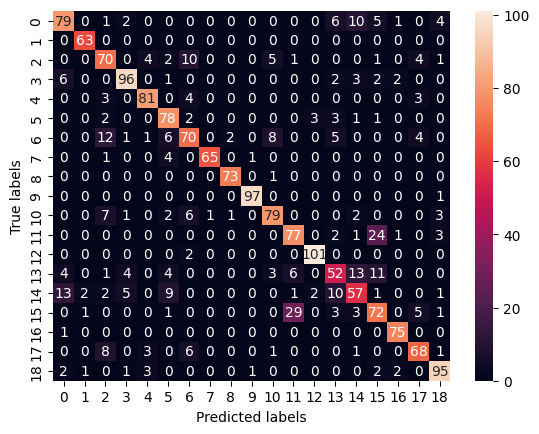

In [25]:
######################
### 2.2 Simple CNN ###
######################
# 25 Epochen
 
# Build the model
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(256,128,1)))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(19, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

# Fit the model
model.fit(X_train, y_train, epochs=25, batch_size=10)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %.2f' % (accuracy*100))
print('Test Loss: %.2f' % (loss*100))

# Confusion Matrix
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  # y_test are the true labels (one-hot encoded)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Epoch 1/10
725/725 [==============================] - 11s 15ms/step - loss: 2.9793 - accuracy: 0.3888
Epoch 2/10
725/725 [==============================] - 11s 15ms/step - loss: 0.8636 - accuracy: 0.7229
Epoch 3/10
725/725 [==============================] - 11s 15ms/step - loss: 0.4505 - accuracy: 0.8527
Epoch 4/10
725/725 [==============================] - 11s 15ms/step - loss: 0.1840 - accuracy: 0.9465
Epoch 5/10
725/725 [==============================] - 11s 15ms/step - loss: 0.0612 - accuracy: 0.9846
Epoch 6/10
725/725 [==============================] - 11s 15ms/step - loss: 0.0293 - accuracy: 0.9935
Epoch 7/10
725/725 [==============================] - 11s 15ms/step - loss: 0.0147 - accuracy: 0.9967
Epoch 8/10
725/725 [==============================] - 11s 15ms/step - loss: 0.0047 - accuracy: 0.9992
Epoch 9/10
725/725 [==============================] - 11s 15ms/step - loss: 2.3410e-04 - accuracy: 1.0000
Epoch 10/10
57/57 [==============================] - 0s 7ms/step - loss: 1.311

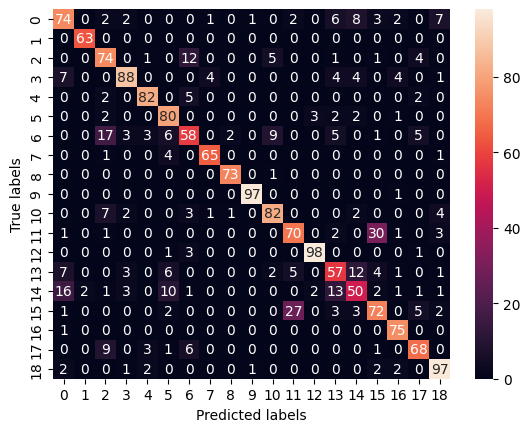

In [9]:
######################
### 2.3 Simple CNN ###
######################
# 10 Epochen

# Build the model
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(256,128,1)))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(19, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

# Fit the model
model.fit(X_train, y_train, epochs=10, batch_size=10)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %.2f' % (accuracy*100))
print('Test Loss: %.2f' % (loss*100))

# Confusion Matrix
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  # y_test are the true labels (one-hot encoded)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Selbst bei nur 10 Epochen ist die Vorhersage-Genauigkeit kaum reduziert. 

2024-01-06 19:43:06.117280: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6943 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1


Epoch 1/10


2024-01-06 19:43:08.655269: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-06 19:43:09.013069: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f1cd20b3340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-06 19:43:09.013093: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-01-06 19:43:09.018046: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1704566589.076863    7075 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


725/725 [==============================] - 8s 8ms/step - loss: 1.6497 - accuracy: 0.4757
Epoch 2/10
725/725 [==============================] - 6s 8ms/step - loss: 0.7152 - accuracy: 0.7610
Epoch 3/10
725/725 [==============================] - 6s 9ms/step - loss: 0.4782 - accuracy: 0.8422
Epoch 4/10
725/725 [==============================] - 6s 9ms/step - loss: 0.3196 - accuracy: 0.8908
Epoch 5/10
725/725 [==============================] - 6s 8ms/step - loss: 0.2128 - accuracy: 0.9286
Epoch 6/10
725/725 [==============================] - 6s 8ms/step - loss: 0.1265 - accuracy: 0.9593
Epoch 7/10
725/725 [==============================] - 6s 8ms/step - loss: 0.0742 - accuracy: 0.9750
Epoch 8/10
725/725 [==============================] - 6s 8ms/step - loss: 0.0519 - accuracy: 0.9837
Epoch 9/10
725/725 [==============================] - 6s 8ms/step - loss: 0.0393 - accuracy: 0.9879
Epoch 10/10
57/57 [==============================] - 1s 9ms/step - loss: 1.0685 - accuracy: 0.8313
Test Accurac

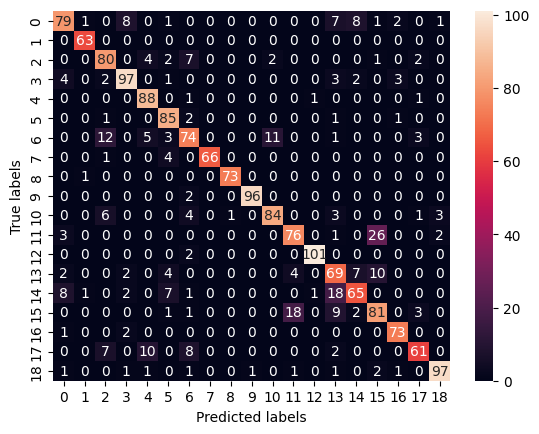

In [5]:
###############
### 3.0 CNN ###
###############
 
# Build the model
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(256,128,1)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(19, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

# Fit the model
model.fit(X_train, y_train, epochs=10, batch_size=10)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %.2f' % (accuracy*100))
print('Test Loss: %.2f' % (loss*100))

# Confusion Matrix
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  # y_test are the true labels (one-hot encoded)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Epoch 1/10
725/725 [==============================] - 7s 8ms/step - loss: 2.1190 - accuracy: 0.3069
Epoch 2/10
725/725 [==============================] - 6s 8ms/step - loss: 0.9491 - accuracy: 0.6668
Epoch 3/10
725/725 [==============================] - 6s 8ms/step - loss: 0.7267 - accuracy: 0.7440
Epoch 4/10
725/725 [==============================] - 6s 8ms/step - loss: 0.5998 - accuracy: 0.7924
Epoch 5/10
725/725 [==============================] - 6s 8ms/step - loss: 0.5184 - accuracy: 0.8185
Epoch 6/10
725/725 [==============================] - 6s 8ms/step - loss: 0.4540 - accuracy: 0.8348
Epoch 7/10
725/725 [==============================] - 6s 8ms/step - loss: 0.3960 - accuracy: 0.8615
Epoch 8/10
725/725 [==============================] - 6s 8ms/step - loss: 0.3528 - accuracy: 0.8732
Epoch 9/10
725/725 [==============================] - 6s 8ms/step - loss: 0.3112 - accuracy: 0.8894
Epoch 10/10
57/57 [==============================] - 1s 7ms/step - loss: 0.5326 - accuracy: 0.8357
T

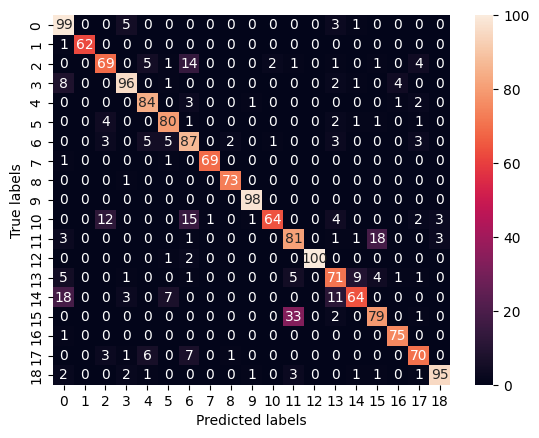

In [6]:
###############
### 3.1 CNN ###
###############
# Add more Convolution Layers
 
# Build the model
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(256,128,1)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(19, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

# Fit the model
model.fit(X_train, y_train, epochs=10, batch_size=10)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %.2f' % (accuracy*100))
print('Test Loss: %.2f' % (loss*100))

# Confusion Matrix
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  # y_test are the true labels (one-hot encoded)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Epoch 1/100
725/725 [==============================] - 6s 8ms/step - loss: 1.6355 - accuracy: 0.4655
Epoch 2/100
725/725 [==============================] - 5s 7ms/step - loss: 0.7708 - accuracy: 0.7316
Epoch 3/100
725/725 [==============================] - 5s 7ms/step - loss: 0.5740 - accuracy: 0.8003
Epoch 4/100
725/725 [==============================] - 5s 7ms/step - loss: 0.4420 - accuracy: 0.8446
Epoch 5/100
725/725 [==============================] - 5s 7ms/step - loss: 0.3482 - accuracy: 0.8786
Epoch 6/100
725/725 [==============================] - 5s 7ms/step - loss: 0.2671 - accuracy: 0.9043
Epoch 7/100
725/725 [==============================] - 5s 7ms/step - loss: 0.2066 - accuracy: 0.9288
Epoch 8/100
725/725 [==============================] - 5s 7ms/step - loss: 0.1468 - accuracy: 0.9497
Epoch 9/100
725/725 [==============================] - 5s 7ms/step - loss: 0.1027 - accuracy: 0.9644
Epoch 10/100
725/725 [==============================] - 5s 7ms/step - loss: 0.0833 - accura

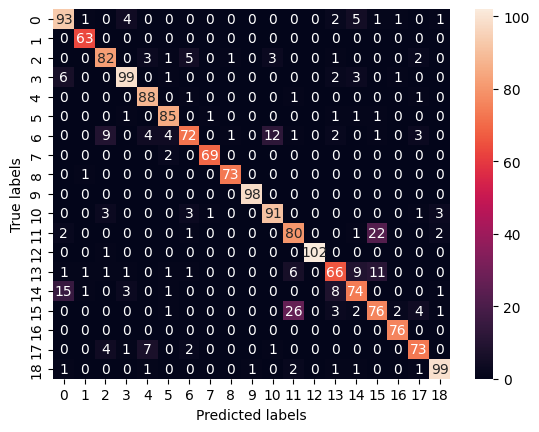

In [9]:
###############
### 3.2 CNN ###
###############
# Add more complex Convolution layers
 
# Build the model
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(256,128,1)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(19, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=10)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %.2f' % (accuracy*100))
print('Test Loss: %.2f' % (loss*100))

# Confusion Matrix
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  # y_test are the true labels (one-hot encoded)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Epoch 1/100
725/725 [==============================] - 7s 8ms/step - loss: 2.1655 - accuracy: 0.2961
Epoch 2/100
725/725 [==============================] - 6s 8ms/step - loss: 0.9607 - accuracy: 0.6644
Epoch 3/100
725/725 [==============================] - 6s 8ms/step - loss: 0.7220 - accuracy: 0.7459
Epoch 4/100
725/725 [==============================] - 6s 8ms/step - loss: 0.5881 - accuracy: 0.7926
Epoch 5/100
725/725 [==============================] - 6s 8ms/step - loss: 0.4943 - accuracy: 0.8281
Epoch 6/100
725/725 [==============================] - 6s 8ms/step - loss: 0.4276 - accuracy: 0.8497
Epoch 7/100
725/725 [==============================] - 6s 8ms/step - loss: 0.3721 - accuracy: 0.8681
Epoch 8/100
725/725 [==============================] - 6s 8ms/step - loss: 0.3329 - accuracy: 0.8794
Epoch 9/100
725/725 [==============================] - 6s 8ms/step - loss: 0.2808 - accuracy: 0.8977
Epoch 10/100
725/725 [==============================] - 6s 8ms/step - loss: 0.2450 - accura

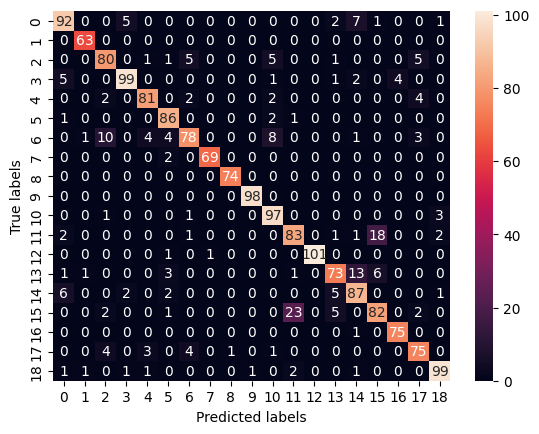

In [11]:
###############
### 3.3 CNN ###
###############
# Over complex Convolution layers
 
# Build the model
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(256,128,1)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(19, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=10)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %.2f' % (accuracy*100))
print('Test Loss: %.2f' % (loss*100))

# Confusion Matrix
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  # y_test are the true labels (one-hot encoded)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

2024-01-06 21:35:56.032945: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6879 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1


Epoch 1/100


2024-01-06 21:35:58.341651: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-06 21:35:58.637838: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f6460926f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-06 21:35:58.637861: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-01-06 21:35:58.642548: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1704573358.699826   10239 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


725/725 [==============================] - 43s 57ms/step - loss: 3.5311 - accuracy: 0.3892
Epoch 2/100
725/725 [==============================] - 42s 57ms/step - loss: 0.9441 - accuracy: 0.6874
Epoch 3/100
725/725 [==============================] - 42s 57ms/step - loss: 0.5851 - accuracy: 0.8026
Epoch 4/100
725/725 [==============================] - 42s 57ms/step - loss: 0.3099 - accuracy: 0.9032
Epoch 5/100
725/725 [==============================] - 42s 57ms/step - loss: 0.1291 - accuracy: 0.9625
Epoch 6/100
725/725 [==============================] - 42s 57ms/step - loss: 0.0668 - accuracy: 0.9833
Epoch 7/100
725/725 [==============================] - 42s 57ms/step - loss: 0.0475 - accuracy: 0.9881
Epoch 8/100
725/725 [==============================] - 42s 58ms/step - loss: 0.0696 - accuracy: 0.9879
Epoch 9/100
725/725 [==============================] - 42s 58ms/step - loss: 0.0599 - accuracy: 0.9894
Epoch 10/100
725/725 [==============================] - 42s 57ms/step - loss: 0.1066 

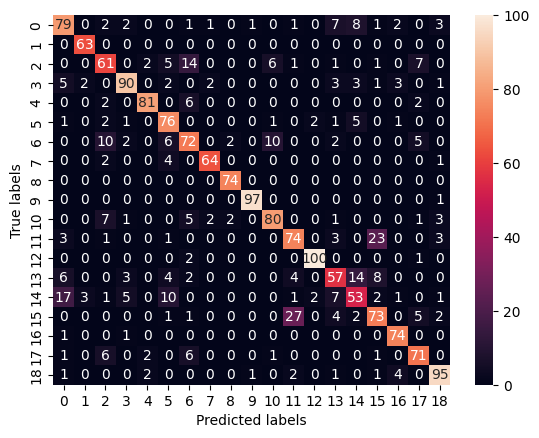

In [5]:
###############
### 3.4 CNN ###
###############
# Starting with more filters
 
# Build the model
model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu', input_shape=(256,128,1)))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(19, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=10)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %.2f' % (accuracy*100))
print('Test Loss: %.2f' % (loss*100))

# Confusion Matrix
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  # y_test are the true labels (one-hot encoded)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

2024-01-06 20:23:09.095668: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6842 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1


Epoch 1/100


2024-01-06 20:23:11.480172: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-06 20:23:11.762529: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f67bcf95460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-06 20:23:11.762552: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-01-06 20:23:11.767184: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1704568991.824377    9149 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


725/725 [==============================] - 43s 57ms/step - loss: 3.1595 - accuracy: 0.3840
Epoch 2/100
725/725 [==============================] - 42s 57ms/step - loss: 0.9456 - accuracy: 0.6872
Epoch 3/100
725/725 [==============================] - 42s 57ms/step - loss: 0.6145 - accuracy: 0.7906
Epoch 4/100
725/725 [==============================] - 42s 57ms/step - loss: 0.3554 - accuracy: 0.8839
Epoch 5/100
725/725 [==============================] - 42s 57ms/step - loss: 0.1768 - accuracy: 0.9444
Epoch 6/100
725/725 [==============================] - 42s 57ms/step - loss: 0.0806 - accuracy: 0.9756
Epoch 7/100
725/725 [==============================] - 42s 57ms/step - loss: 0.0400 - accuracy: 0.9905
Epoch 8/100
725/725 [==============================] - 42s 57ms/step - loss: 0.0350 - accuracy: 0.9920
Epoch 9/100
725/725 [==============================] - 42s 57ms/step - loss: 0.0298 - accuracy: 0.9941
Epoch 10/100
725/725 [==============================] - 42s 57ms/step - loss: 0.0267 

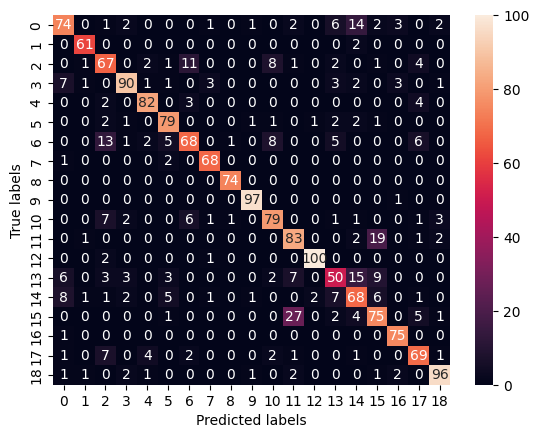

In [5]:
###############
### 3.5 CNN ###
###############
# Make padding='same'
 
# Build the model
model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu', input_shape=(256,128,1), padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(19, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=10)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %.2f' % (accuracy*100))
print('Test Loss: %.2f' % (loss*100))

# Confusion Matrix
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  # y_test are the true labels (one-hot encoded)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

2024-01-06 22:56:57.173507: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6819 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1


Epoch 1/100


2024-01-06 22:56:59.526919: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-06 22:56:59.817310: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff664d2f990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-06 22:56:59.817333: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-01-06 22:56:59.822090: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1704578219.880520   11856 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


725/725 [==============================] - 42s 56ms/step - loss: 2.7701 - accuracy: 0.3806
Epoch 2/100
725/725 [==============================] - 41s 56ms/step - loss: 0.9473 - accuracy: 0.7017
Epoch 3/100
725/725 [==============================] - 41s 56ms/step - loss: 0.5758 - accuracy: 0.8072
Epoch 4/100
725/725 [==============================] - 41s 56ms/step - loss: 0.3644 - accuracy: 0.8778
Epoch 5/100
725/725 [==============================] - 41s 56ms/step - loss: 0.2389 - accuracy: 0.9273
Epoch 6/100
725/725 [==============================] - 41s 56ms/step - loss: 0.1583 - accuracy: 0.9566
Epoch 7/100
725/725 [==============================] - 41s 56ms/step - loss: 0.1149 - accuracy: 0.9698
Epoch 8/100
725/725 [==============================] - 41s 56ms/step - loss: 0.0721 - accuracy: 0.9834
Epoch 9/100
725/725 [==============================] - 41s 56ms/step - loss: 0.0589 - accuracy: 0.9870
Epoch 10/100
725/725 [==============================] - 41s 56ms/step - loss: 0.0486 

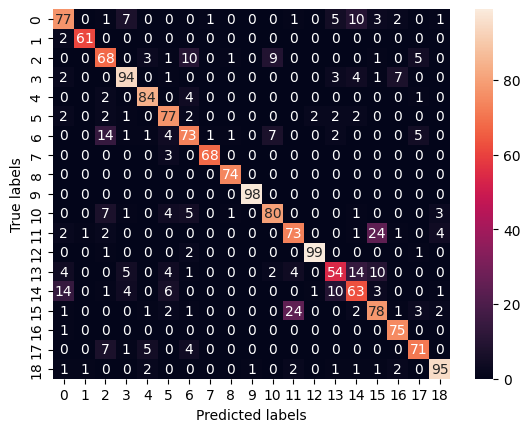

In [5]:
###############
### 3.6 CNN ###
###############
# Greater filter
 
# Build the model
model = Sequential()
model.add(Conv2D(64, (5,5), activation='relu', input_shape=(256,128,1)))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(19, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=10)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %.2f' % (accuracy*100))
print('Test Loss: %.2f' % (loss*100))

# Confusion Matrix
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  # y_test are the true labels (one-hot encoded)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

2024-01-07 15:08:54.377780: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7144 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1


Epoch 1/100


2024-01-07 15:08:56.774011: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-07 15:08:57.462547: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f263552fbe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-07 15:08:57.462570: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-01-07 15:08:57.477421: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1704636537.559978    5435 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


725/725 [==============================] - 21s 26ms/step - loss: 2.8090 - accuracy: 0.3662
Epoch 2/100
725/725 [==============================] - 19s 26ms/step - loss: 0.8916 - accuracy: 0.7178
Epoch 3/100
725/725 [==============================] - 19s 26ms/step - loss: 0.4817 - accuracy: 0.8429
Epoch 4/100
725/725 [==============================] - 19s 26ms/step - loss: 0.2031 - accuracy: 0.9382
Epoch 5/100
725/725 [==============================] - 19s 26ms/step - loss: 0.0663 - accuracy: 0.9830
Epoch 6/100
725/725 [==============================] - 19s 26ms/step - loss: 0.0245 - accuracy: 0.9937
Epoch 7/100
725/725 [==============================] - 19s 26ms/step - loss: 0.0135 - accuracy: 0.9967
Epoch 8/100
725/725 [==============================] - 19s 26ms/step - loss: 0.0094 - accuracy: 0.9982
Epoch 9/100
725/725 [==============================] - 19s 26ms/step - loss: 0.0312 - accuracy: 0.9971
Epoch 10/100
725/725 [==============================] - 19s 26ms/step - loss: 0.0035 

725/725 [==============================] - 19s 26ms/step - loss: 1.4955e-07 - accuracy: 1.0000
Epoch 78/100
725/725 [==============================] - 19s 26ms/step - loss: 1.4867e-07 - accuracy: 1.0000
Epoch 79/100
725/725 [==============================] - 19s 26ms/step - loss: 1.4442e-07 - accuracy: 1.0000
Epoch 80/100
725/725 [==============================] - 19s 26ms/step - loss: 1.4417e-07 - accuracy: 1.0000
Epoch 81/100
725/725 [==============================] - 19s 26ms/step - loss: 1.4149e-07 - accuracy: 1.0000
Epoch 82/100
725/725 [==============================] - 19s 26ms/step - loss: 1.3958e-07 - accuracy: 1.0000
Epoch 83/100
725/725 [==============================] - 19s 26ms/step - loss: 1.3536e-07 - accuracy: 1.0000
Epoch 84/100
725/725 [==============================] - 19s 26ms/step - loss: 1.3562e-07 - accuracy: 1.0000
Epoch 85/100
725/725 [==============================] - 19s 26ms/step - loss: 1.3190e-07 - accuracy: 1.0000
Epoch 86/100
725/725 [===================

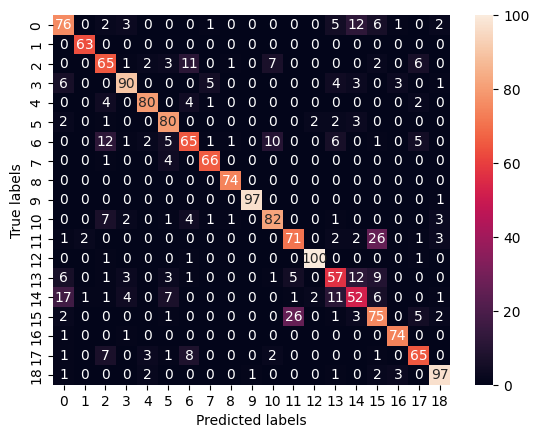

In [5]:
###############
### 3.7 CNN ###
###############
# More density (reducing number of starting filters)

# Build the model
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(256,128,1)))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(19, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=10)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %.2f' % (accuracy*100))
print('Test Loss: %.2f' % (loss*100))

# Confusion Matrix
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  # y_test are the true labels (one-hot encoded)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Epoch 1/100
725/725 [==============================] - 9s 10ms/step - loss: 2.2980 - accuracy: 0.2526
Epoch 2/100
725/725 [==============================] - 7s 10ms/step - loss: 0.9253 - accuracy: 0.6799
Epoch 3/100
725/725 [==============================] - 6s 9ms/step - loss: 0.6787 - accuracy: 0.7599
Epoch 4/100
725/725 [==============================] - 7s 9ms/step - loss: 0.5528 - accuracy: 0.8015
Epoch 5/100
725/725 [==============================] - 7s 10ms/step - loss: 0.4796 - accuracy: 0.8295
Epoch 6/100
725/725 [==============================] - 7s 10ms/step - loss: 0.4116 - accuracy: 0.8503
Epoch 7/100
725/725 [==============================] - 7s 10ms/step - loss: 0.3645 - accuracy: 0.8697
Epoch 8/100
725/725 [==============================] - 7s 10ms/step - loss: 0.3166 - accuracy: 0.8891
Epoch 9/100
725/725 [==============================] - 7s 10ms/step - loss: 0.2907 - accuracy: 0.8972
Epoch 10/100
725/725 [==============================] - 7s 10ms/step - loss: 0.2586 

725/725 [==============================] - 7s 9ms/step - loss: 0.0777 - accuracy: 0.9898
Epoch 81/100
725/725 [==============================] - 7s 9ms/step - loss: 0.0788 - accuracy: 0.9880
Epoch 82/100
725/725 [==============================] - 7s 9ms/step - loss: 0.0611 - accuracy: 0.9906
Epoch 83/100
725/725 [==============================] - 6s 9ms/step - loss: 0.0819 - accuracy: 0.9903
Epoch 84/100
725/725 [==============================] - 7s 9ms/step - loss: 0.0917 - accuracy: 0.9883
Epoch 85/100
725/725 [==============================] - 7s 10ms/step - loss: 0.0739 - accuracy: 0.9909
Epoch 86/100
725/725 [==============================] - 7s 10ms/step - loss: 0.0603 - accuracy: 0.9912
Epoch 87/100
725/725 [==============================] - 7s 10ms/step - loss: 0.0872 - accuracy: 0.9881
Epoch 88/100
725/725 [==============================] - 7s 9ms/step - loss: 0.0344 - accuracy: 0.9956
Epoch 89/100
725/725 [==============================] - 7s 9ms/step - loss: 0.0432 - accurac

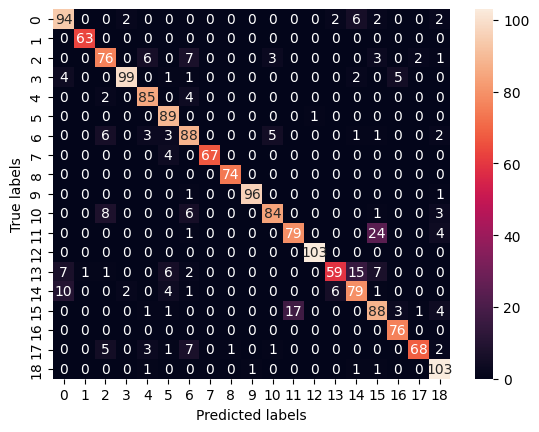

In [7]:
###############
### 3.8 CNN ###
###############
# Over complex Convolution layers
 
# Build the model
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(256,128,1)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(16, (5,5), activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (5,5), activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (5,5), activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(19, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=10)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %.2f' % (accuracy*100))
print('Test Loss: %.2f' % (loss*100))

# Confusion Matrix
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  # y_test are the true labels (one-hot encoded)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Test Loss: 404.08
